This notebook will try to explore the effectiveness of prknn vs standard knn models for prediction on an inbalanced dataset.   

In [14]:
from pathlib import Path
import os
import sys
cwd = Path(os.getcwd())
prnt = cwd.parent
while prnt.parts[-1] != 'Proximal_ratio_knn-':
    prnt = prnt.parent

root = prnt.as_posix() 
sys.path.append(root)



In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, TargetEncoder

from sklearn.impute import KNNImputer

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

from PRKNNClassifier.test_class import PRKNeighborsClassifier
from tqdm import tqdm

import seaborn as sns


In [16]:
RANDOM_STATE = 33

In [17]:
df = pd.read_csv(root + '/datasets/train_data.csv')

In [18]:
df.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [19]:
columns_to_drop = [
    "Hospital_region_code",
    "Ward_Facility_Code",
    "case_id",
    "patientid",
    "Hospital_code",
    "City_Code_Patient",
    "Admission_Deposit",
    # "Available Extra Rooms in Hospital",
    "Bed Grade",
    "City_Code_Hospital",
    "Visitors with Patient",
    "Hospital_type_code",
    # "Type of Admission",
    "Department"
]

df = df.drop(columns_to_drop, axis=1)

In [20]:
df.isna().sum()

Available Extra Rooms in Hospital    0
Ward_Type                            0
Type of Admission                    0
Severity of Illness                  0
Age                                  0
Stay                                 0
dtype: int64

For categoric variables, I am going to use frequency encoding, due to the high number of categoric features and their high cardinality. I am also concerned that target encoding may lead to data leakage due to the low frequencies of the target variable. While other techniques may be better, the aim is to test the effectiveness of prknn compared to knn.

In [21]:
categoric_columns = [
    'Hospital_type_code',
    'City_Code_Hospital',
    'Department', 
    'Ward_Type',
    'City_Code_Patient', 
    'Type of Admission'
]

ordinal_columns = [
    'Bed Grade',
    'Severity of Illness'
]

cont_columns = [
    'Available Extra Rooms in Hospital',
    'Visitors with Patient',
    'Age',
    'Admission_Deposit'
]

In [22]:
def remove_fields(cols:list, columns_to_drop):

    cols2 = []

    for col in cols:
        if not col in columns_to_drop:
            cols2.append(col)
            # print(cols)

    return cols2

In [23]:
categoric_columns = remove_fields(categoric_columns, columns_to_drop) 
ordinal_columns = remove_fields(ordinal_columns, columns_to_drop)
cont_columns = remove_fields(cont_columns, columns_to_drop)

In [24]:
categoric_columns

['Ward_Type', 'Type of Admission']

In [25]:
# col_transformer = ColumnTransformer(
#     transformers=[
#         ('target', TargetEncoder(), categoric_columns),
#         ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns)
#     ]
# )

# prknn_pipeline_list = [
#     ('col_transform', col_transformer),
#     ('scaler', MinMaxScaler()),
#     ('knn_imputer', KNNImputer(n_neighbors=10, weights='distance')),
#     ('prknn_predictor', PRKNeighborsClassifier(base_knn_params={"n_neighbors": 3}))
# ]

# knn_pipeline_list = [
#     ('col_transform', col_transformer),
#     ('scaler', MinMaxScaler()),
#     ('knn_imputer', KNNImputer(n_neighbors=10, weights='distance')),
#     ('knn_predictor', KNeighborsClassifier(n_neighbors=3))
# ]


# prknn_pipeline = Pipeline(prknn_pipeline_list)
# knn_pipeline = Pipeline(knn_pipeline_list)

In [26]:
df_sample = df.sample(5_000)

X = df_sample.drop('Stay', axis=1)
y = df_sample['Stay']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=RANDOM_STATE)

In [27]:

y_train.value_counts()

Stay
21-30                 1049
11-20                 1010
31-40                  685
51-60                  478
0-10                   290
41-50                  148
71-80                  123
More than 100 Days      78
81-90                   66
61-70                   42
91-100                  31
Name: count, dtype: int64

In [28]:



ordinal_encoder = OrdinalEncoder()

y_train = ordinal_encoder.fit_transform(pd.DataFrame(y_train)).ravel()
y_test = ordinal_encoder.fit_transform(pd.DataFrame(y_test)).ravel()

col_transformer = ColumnTransformer(
    transformers=[
        ('target', TargetEncoder(), categoric_columns),
        ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), ordinal_columns)
    ]
)

prknn_pipeline_pre_list = [
    ('col_transform', col_transformer),
    ('scaler', MinMaxScaler()),
    ('knn_imputer', KNNImputer(n_neighbors=10, weights='distance'))
]

scoring = ["f1_macro", "f1_micro", "accuracy"]

prknn_versions = ["standard", "weighted", "enhanced"]

k_values = [3, 5, 15, 30, 45, 60, 75, 100, 150]

prknn_scores_dict = {}

for v in prknn_versions:
    for k in tqdm(k_values):
        prknn_pipeline_list = prknn_pipeline_pre_list.copy()
        
        prknn_pipeline_list.append(
            ('prknn_predictor', PRKNeighborsClassifier(pr_version=v, base_knn_params={"n_neighbors": k}))
        )


        prknn_pipeline = Pipeline(prknn_pipeline_list)
        prknn_scores_dict[v, k] = cross_validate(prknn_pipeline, X_train, y_train, cv=5, scoring=scoring)


100%|██████████| 9/9 [22:08<00:00, 147.66s/it]


In [29]:
def plot_cv_scores(score_dict, pr_version, score, k_values):

    fig, ax = plt.subplots()
    scores_arr = np.array([score_dict[pr_version, k][score] for k in k_values])
    scores_arr = np.average(scores_arr, axis=1)

    ax.plot(scores_arr)
    ax.set_ylabel(score)
    ax.set_xticklabels([0] + k_values)



C:\Users\josep\AppData\Local\Temp\ipykernel_40528\823967553.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0] + k_values)
C:\Users\josep\AppData\Local\Temp\ipykernel_40528\823967553.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0] + k_values)
C:\Users\josep\AppData\Local\Temp\ipykernel_40528\823967553.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([0] + k_values)


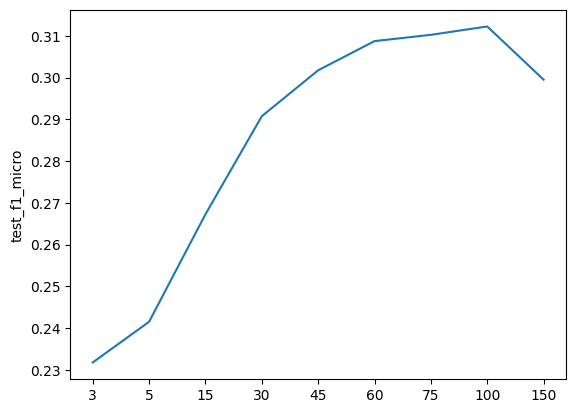

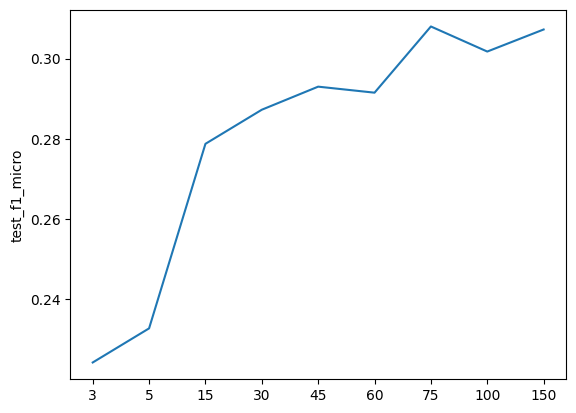

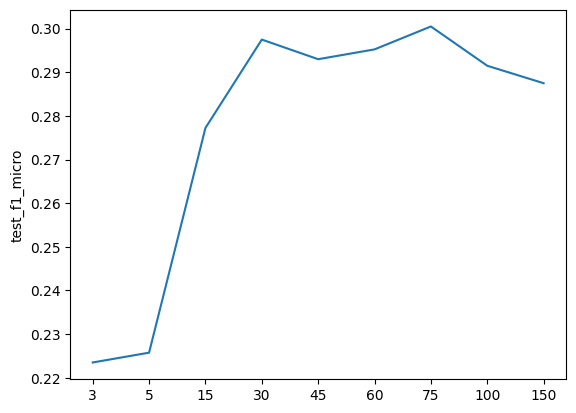

In [30]:

plot_cv_scores(prknn_scores_dict, "standard", "test_f1_micro", k_values)
plot_cv_scores(prknn_scores_dict, "weighted", "test_f1_micro", k_values)
plot_cv_scores(prknn_scores_dict, "enhanced", "test_f1_micro", k_values)

In [31]:
f1_standard = np.average(np.array([prknn_scores_dict['standard', k]['test_f1_micro'] for k in k_values]), axis=1)
best_k_standard = k_values[np.argmax(f1_standard)]

f1_weighted = np.average(np.array([prknn_scores_dict['weighted', k]['test_f1_micro'] for k in k_values]), axis=1)
best_k_weighted = k_values[np.argmax(f1_weighted)]

f1_enhanced = np.average(np.array([prknn_scores_dict['enhanced', k]['test_f1_micro'] for k in k_values]), axis=1)
best_k_enhanced = k_values[np.argmax(f1_enhanced)]

In [32]:
print(f"The best standard model had a k of {best_k_standard} with an f1_micro of {np.max(f1_standard)}")
print(f"The best weighted model had a k of {best_k_weighted} with an f1_micro of {np.max(f1_weighted)}")
print(f"The best enhanced model had a k of {best_k_enhanced} with an f1_micro of {np.max(f1_enhanced)}")

The best standard model had a k of 100 with an f1_micro of 0.31225
The best weighted model had a k of 75 with an f1_micro of 0.30800000000000005
The best enhanced model had a k of 75 with an f1_micro of 0.3005


In [33]:
# fit model with the standard model and a k of 75
prknn_pipeline_list = prknn_pipeline_pre_list.copy()
        
prknn_pipeline_list.append(
    ('prknn_predictor', PRKNeighborsClassifier(pr_version="enhanced", base_knn_params={"n_neighbors": best_k_standard}))
)

prknn_pipeline= Pipeline(prknn_pipeline_list)
prknn_pipeline.fit(X_train, y_train)
y_pred = prknn_pipeline.predict(X_test)

print(f"f1 score: {f1_score(y_test, y_pred, average="micro")}")


f1 score: 0.253


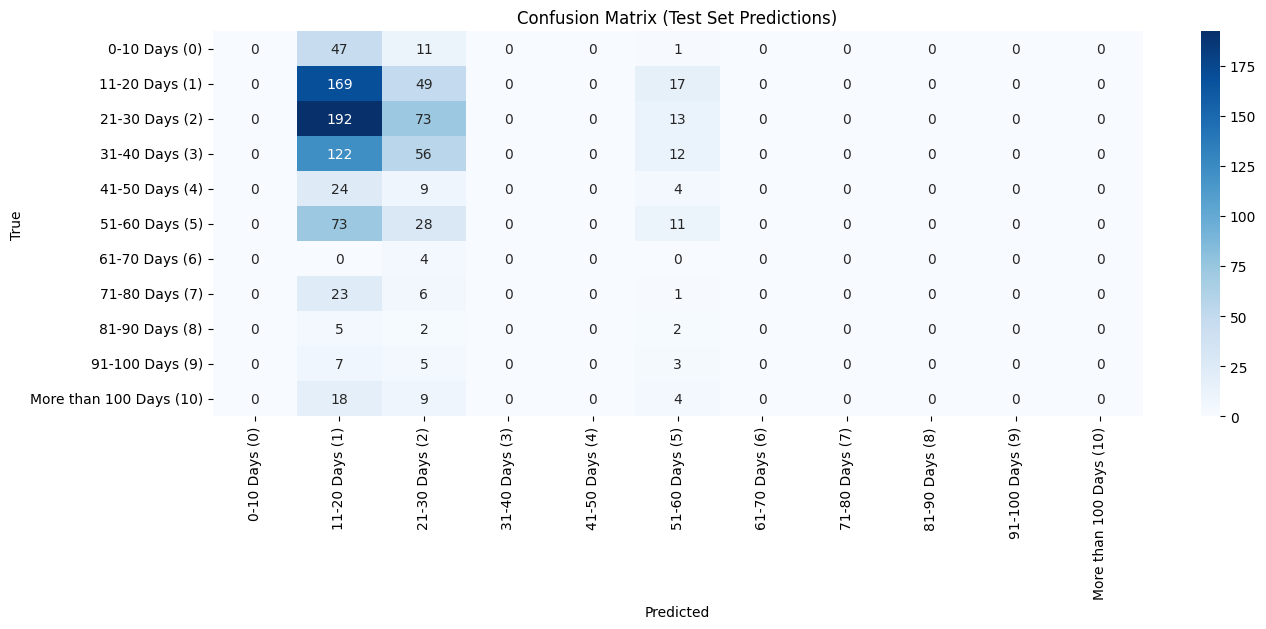

In [34]:
cm = confusion_matrix(y_test, y_pred)

class_labels = [
    "0-10 Days (0)", "11-20 Days (1)", "21-30 Days (2)", "31-40 Days (3)",
    "41-50 Days (4)", "51-60 Days (5)", "61-70 Days (6)", "71-80 Days (7)",
    "81-90 Days (8)", "91-100 Days (9)", "More than 100 Days (10)"
]

# Visualize the confusion matrix with class labels
plt.figure(figsize=(15, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set Predictions)')
plt.show()